# simulating minimalist modified oscillatory particle model
Tim Tyree<br>
4.27.2023

In [1]:
from lib.my_initialization import *

/Users/timothytyree/opt/miniconda3/envs/pyenv/lib/python3.9/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
plt.plot([1]*4)
plt.close()
#reset matplotlib
import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
mpl.rcParams.update(matplotlib.rcParamsDefault) #reset matplotlib

In [3]:
kwargs = dict(data_fk_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_fk_tt.csv',
              data_lr_dir=f'{nb_dir}/data/full_results/data_fig4_vidmar_lr_tt.csv',
             min_num_particles=9)

dict_wjr = recall_death_rates_vidmar_rappel(**kwargs)
fk=dict_wjr['fk']
lr=dict_wjr['lr']
print(f"annihilation rate density powerlaw fits:")
dict_fit_death_fk = print_fit_power_law(x=fk['q'].values,y=fk['w'].values)
dict_fit_death_lr = print_fit_power_law(x=lr['q'].values,y=lr['w'].values)

annihilation rate density powerlaw fits:
m = 1.877234 +/- 0.024488
M = 5.572316 +/- 0.299027 Hz/cm^2; B=2.496963 +/- 0.039522
RMSE=0.1386 Hz/cm^2; R^2=0.9969; MPE=6.9910%; N=73
m = 1.637556 +/- 0.016847
M = 16.735599 +/- 0.829136 Hz/cm^2; B=5.587740 +/- 0.065801
RMSE=0.1340 Hz/cm^2; R^2=0.9973; MPE=7.2488%; N=100


# define module

In [4]:
@njit
def find_min(dmin,xl):
    """xl is the size of the periodic dimension occupied by the elements of dmin"""
    xmin = 2.*xl
    imin=0
    for i in range(3):
        d=dmin[i]
        if d<xmin:
            xmin=d
            imin=i
    if imin==0:
        return 0.
    elif imin==1:
        return xl
    else:
        return -xl

In [5]:
@njit
def distance_kernel_opm(x,y,L,N,
        distance,disp_x,disp_y,
        still_running,reflect,dmin):
    """
    Example Usage:
distance_kernel_opm(x,y,L,N,
        distance,disp_x,disp_y,
        still_running,reflect,dmin)
    """
    for i in range(N): 
        if still_running[i]:
            for j in range(i+1,N):
                if (still_running[j]) & (i!=j):
                    if reflect==1:
                        dx=x[i]-x[j];
                        dy=y[i]-y[j];
                    else:  
                        #handle periodic b.c.
                        dmin[0]=np.abs(x[i]-x[j]);
#                         dmin[1]=np.abs(x[i]-L-x[j]);
#                         dmin[2]=np.abs(x[i]+L-x[j]);
                        dmin[1]=np.abs(x[i]+L-x[j]);  #<<< originally used
                        dmin[2]=np.abs(x[i]-L-x[j]);#<<< originally used
                        facx = find_min(dmin,L);
                        dmin[0]=np.abs(y[i]-y[j]);
#                         dmin[1]=np.abs(y[i]-L-y[j]);
#                         dmin[2]=np.abs(y[i]+L-y[j]);
                        dmin[1]=np.abs(y[i]+L-y[j]);#<<< originally used
                        dmin[2]=np.abs(y[i]-L-y[j]);#<<< originally used
                        facy = find_min(dmin,L);
                        dx=x[i]+facx-x[j];
                        dy=y[i]+facy-y[j];
                    dist2 = dx**2 + dy**2
                    # record distance and displacement
                    distance[i][j]=dist2;
                    distance[j][i]=dist2;
                    disp_x[i,j]=-dx;
                    disp_y[i,j]=-dy;
                    disp_x[j,i]=dx;
                    disp_y[j,i]=dy;

In [6]:
@njit
def normalRandomArray(N):
    return np.random.normal(0,1,N)

@njit
def one_step_kernel_opm(x,y,phi,N,L,randarr,distance,chirality,
                       still_running,icaught,
                       phistep,duhstep,diffstep,impulse,impulse0,R0):
    """
    Example Usage:
randarr = normalRandomArray(N*3)
one_step_kernel_opm(x,y,phi,N,L,randarr,distance,chirality,
                       still_running,icaught,
                       phistep,duhstep,diffstep,impulse,impulse0,R0)
    """
    #one_step_kernel_opm
    for i in range(N): 
        if still_running[i]:
            x[i] = x[i] + diffstep*randarr[i+2*N]
            x[i] = x[i] + diffstep*randarr[i+N]
            if (icaught[i]==-1):
                phi[i] = phi[i] + chirality[i]*phistep + duhstep*randarr[i]
                x[i] = x[i] + impulse/R0*np.cos(phi[i])
                y[i] = y[i] + impulse/R0*np.sin(phi[i])
            else:
                #GOAL: dev one step for attracting phase
                # #find nearest neighbor as ineighbor
                # mindist=2.*L
                # ineighbor=i
                # for j in range(N):
                #     if still_running[j] & (~still_wandering[j]) & (i!=j):
                #         if mindist>distance[i,j]:
                #             mindist=distance[i,j]
                #             ineighbor=j
                #recall distance to nearest neighbor
                #R = np.sqrt(mindist)
                #R = np.sqrt(distance[i,ineighbor])  
                SR=distance[i,icaught[i]]
                if SR<=2e-2:
                    SR=2e-2
                    #SR=9e9
                    
                #add oscillatory force
#                 R = np.sqrt(SR)  
#                 x[i] = x[i] + impulse/R*np.cos(phi[i])
#                 y[i] = y[i] + impulse/R*np.sin(phi[i])
                x[i] = x[i] + impulse/R0*np.cos(phi[i])
                y[i] = y[i] + impulse/R0*np.sin(phi[i])
                phi[i] = phi[i] + chirality[i]*phistep
            
                #add attractive force
                Dx = disp_x[i,icaught[i]]/SR
                Dy = disp_y[i,icaught[i]]/SR
                x[i] = x[i] - impulse0*Dx   #yields fewer stray caught pairs
                y[i] = y[i] - impulse0*Dy   #yields fewer stray caught pairs
#                 x[i] = x[i] + impulse0*Dx  #<<< visibly diverges caught pairs at long time scales
#                 y[i] = y[i] + impulse0*Dy  #<<< visibly diverges caught pairs at long time scales


In [7]:
@njit
def reflection(x, L):
    return L-np.abs(L-np.abs(x%(2.*L)))

@njit
def enforce_bc_kernel(x,y,N,L,still_running,reflect):
    """
    Example Usage:
enforce_bc_kernel(x,y,N,L,still_running,reflect)
    """
    #enforce boundary conditions
    for i in range(N):
        if still_running[i]:
            if reflect==1:
                #enforce reflecting boundary conditions
                x[i] = reflection(x[i], L)
                y[i] = reflection(y[i], L)
            else:
                #enforce periodic boundary conditions
                if (x[i]>L):
                    x[i]=x[i]-L;
                elif (x[i]<0.):
                    x[i]=x[i]+L;
                if (y[i]>L):
                    y[i]=y[i]-L;
                elif (y[i]<0.):
                    y[i]=y[i]+L;

In [8]:
@njit
def catch_kernel_opm(phi,disp_x,disp_y,distance,still_running,icaught,chirality,
                    N,rxn_rng,phidiff_thresh,rxnstep):
    """
    Example Usage:
catch_kernel_opm(phi,disp_x,disp_y,distance,still_running,icaught,chirality,
                    N,rxn_rng,phidiff_thresh,rxnstep)
    """
    for i in range(N): 
        #if still_wandering and still_running
        if still_running[i] and (icaught[i]==-1):  
            #determine whether to start a reaction
            chiral=chirality[i]
            for j in range(i+1,N): 
                if still_running[j] and (icaught[j]==-1):  
                    if (chiral*chirality[j]==-1): #if opposite handed
                        dist2=distance[i,j]
                        #catching mode determination
                        if (dist2<rxn_rng) & (dist2>0): # if within rxn range, ignoring collocalization edge cases
                            #determine whether phases match
                            dist = np.sqrt(dist2)
                            dy = disp_y[i,j]/dist
                            dx = disp_x[i,j]/dist
                            vx = np.cos(phi[i]) + np.cos(phi[j])  #x velocity in units of v0
                            vy = np.sin(phi[i]) + np.sin(phi[j])  #y velocity in units of v0
                            #if (vx,vy)=v1+v2 is also larger in magnitude than v1*sin(phi) and v2*np.sin
                            if (vx*dx + vy*dy)<phidiff_thresh: #if phases match
                                cs1=np.cos(phi[i])*dy - np.sin(phi[i])*dx
                                cs2=np.cos(phi[j])*dy - np.sin(phi[j])*dx
                                acr=np.abs(vx*dy - vy*dx)
                                if (acr>cs1) & (acr>cs2):
                                    #then the catch is valid
                                    # start reaction with prob kappa*dt
                                    if (np.random.uniform(1,0,1)<=rxnstep):
                                        #set pair to be in "caught" mode
                                        icaught[i]=j
                                        icaught[j]=i

In [9]:
@njit
def iter_over_pairs(N,still_running):
    for i in range(N):
        if still_running[i]:
            for j in range(i+1,N):
                if still_running[j]:
                    yield i,j

In [10]:
def plotter_opm(x,y,phi,colors,L,text,fontsize,**kwargs):
    ax.quiver(x, y, np.cos(phi), np.sin(phi), angles="xy",scale = 30,width = 0.004,
              color=colors,**kwargs)
    ax.annotate(text,xy=(0.6,0.02),fontsize=fontsize,xycoords='axes fraction')
    ax.axis([0,L,0,L])
    ax.axis('off')
    return ax

In [11]:
# @njit
# def normalRandom(): 
#     """normalRandom returns a normally distributed random value.
    
#     Example Usage:
# print(f"{normalRandom()=}")
#     """
#     v1=np.random.uniform()
#     v2=np.random.uniform()
#     return np.cos(2.*3.141592653589793*v2)*np.sqrt(-2.*np.log(v1));


# dev simulation of OPM

In [12]:
# dt = 1e-4 #s
dt = 1e-5 #s
NL = 12 #number of rows/columns
N = NL**2 #on a square grid
L=5. #cm

#Luo-Rudy force model
a0 = 4.2 #cm^2/s
# a0=0
a1 = 12.18 #cm^2/s
D = 0.42 #cm^2/s
# D=0 
T=0.0974#s  

# alinear=10.147
# alinear=9.3#9.3154
# r=1.55; kappa=10000
r=0.155; kappa=300
# r=0.5  
r=0.3; kappa=300
# r=0.2500; kappa=300
# r=0.135; kappa=60
# kappa=60
# kappa=100; r=0.125
# r=1.55; kappa=1/dt
N_end=1

Duh=0.125 #rad^2/s
# Duh=1.25 #rad^2/s
# Duh=2 #rad^2/s #
Duh=10 #rad^2/s  #
#heretim
#Q: which is Duh best?

# Duh=10.25 #rad^2/s
chi=1.  # chi=1. is the trivial case, setting the rotational scale to the capture range
# chi=0.5
R0 = chi*r #cm
# R0 = 2 #cm
# R0 = 0.5 #cm  #<<< looks reasonable at # Duh=1.25 #rad^2/s
# R0 = 0.25 #cm
# R0 = 0.2 #cm
#heretim


seed=42
reflect=0
use_random_ic=False
#define the system variables
dtype='float64'
disp_x=np.zeros((N,N),dtype=dtype)
disp_y=np.zeros((N,N),dtype=dtype)
distance=np.zeros((N,N),dtype=dtype)

#heretim
epsilon=(0.155)**2 #cm^2
# epsilon=2e-2 #cm^2
# epsilon=5e-2 #cm^2  #<<< no stray tips
# epsilon=1e-2 #cm^2
# epsilon=1e-4 #cm^2  #annihilated tips appear colocalized
epsilon_kappa=1e4 #Hz  
# epsilon_kappa = 1/dt #trivial / instantaneous remove when within distance epsilon
rmvstep = epsilon_kappa*dt
phidiff_thresh=np.sin(1e-3) #radians
# phidiff_thresh=np.sin(1e-1) #radians
icaught=np.zeros(N,dtype='int')-1
still_running=np.ones(N,dtype='int')==1
dmin=np.zeros(3)



#define the system constants
omega0 = 2*np.pi/T #rad/s
rxnstep = kappa*dt
phistep = omega0*dt #rad/s
duhstep = np.sqrt(2*Duh*dt) #rad/s
# impulse = alinear*dt # cm^2
impulse = a1*dt # cm^2
# impulse0 = (a1+2*D)*dt # cm^2
impulse0 = a0*dt # cm^2
diffstep = np.sqrt(2*D*dt)
rxn_rng = r**2 #cm^2

print(f"catchings start at {np.sqrt(rxn_rng)=:.3f} cm.")
print(f"removals start at {np.sqrt(epsilon)=:.3f} cm.")

chirality=np.ones(N,dtype='int')
#set every other chirality to -1
boo=False
for i in range(N):
    if boo:
        chirality[i]*=-1
    boo = not boo

catchings start at np.sqrt(rxn_rng)=0.300 cm.
removals start at np.sqrt(epsilon)=0.155 cm.


In [13]:
Tsum_array=np.zeros(N+1,dtype=dtype)
Tcount_array=np.zeros(N+1,dtype='int')

In [14]:
#for snapshot output
save_folder=f"{nb_dir}/Figures/mov"
if os.path.exists(save_folder):
    #cleanse the old snapshot folder
    shutil.rmtree(save_folder)
os.mkdir(save_folder)
frameno=1
save_fn=None
inch=6
annotating=True
message='osc. particle model'

In [15]:
niter=1500
np.random.seed(seed)
for q in range(niter):
    pass
# use_random_ic=True
# use_random_ic=False
nparticles=N

#define the initial condition of the system
phi = (np.random.uniform(size=N)*2*np.pi).astype(dtype)
x = (np.linspace(0+0.5/NL, 1-0.5/NL, NL))*L
y = (np.linspace(0+0.5/NL, 1-0.5/NL, NL))*L
x, y = np.meshgrid(x, y)
x = x.flatten()
y = y.flatten()
if use_random_ic:
    x = (np.random.uniform(size=N)*L).astype(dtype)
    y = (np.random.uniform(size=N)*L).astype(dtype)
print(f"the system is initialized (seed: {seed}).")

colors=[]
for c in chirality:
    if c==-1:
        colors.append('k')
    else:
        colors.append('gray')

the system is initialized (seed: 42).


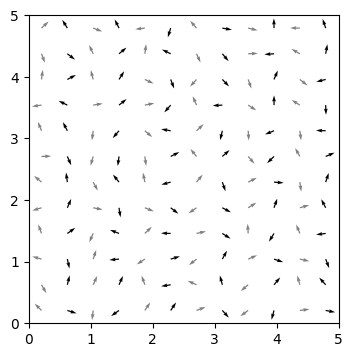

In [16]:
plt.subplots(figsize=(4,4))
plt.quiver(x, y, np.cos(phi), np.sin(phi), angles="xy",scale = 32,width = 0.004,
          color=colors)
plt.axis([0,L,0,L])
plt.show()

In [17]:
3*N

432

In [18]:
# #TODO: get catcher kernel to use sin instead of cos to make two tips "caught"
# #DONE: get ^that snap shot looking reasonable
# #DONE: save to save_folder, as before
# # Figures/mov/img%07d.png
# save_folder = f"{nb_dir}/Figures/mov"
# save_folder
# randarr = normalRandomArray(3*N) # +0
# randarr = np.random.normal(0,1,3*N)
# from numba import njit 

In [19]:
t=0.
frameno=0
fontsize=16
save_every=100
# save_every=200
printing=True
num_steps = 50000
#distance_kernel_opm
distance_kernel_opm(x,y,L,N,  #<<< gives the run time +15s per 100000 calls
        distance,disp_x,disp_y,
        still_running,reflect,dmin)

for step in range(num_steps):
    #normal random number generation 
    #randarr = normalRandomArray(3*N) # +0s run time per 100000 calls
    randarr = np.random.normal(0,1,3*N)
    #motion
    one_step_kernel_opm(x,y,phi,N,L,randarr,distance,chirality, # +0s run time per 100000 calls
                       still_running,icaught,
                       phistep,duhstep,diffstep,impulse,impulse0,R0)
    #enforce pbc if reflect is not 1
    enforce_bc_kernel(x,y,N,L,still_running,reflect)
    #distance_kernel_opm
    distance_kernel_opm(x,y,L,N,  #<<< gives the run time +15s per 100000 calls
            distance,disp_x,disp_y,
            still_running,reflect,dmin)
    #determine any new captured modes
    catch_kernel_opm(phi,disp_x,disp_y,distance,still_running,icaught,chirality,  ## +34.5s run time per 100000 calls
                        N,rxn_rng,phidiff_thresh,rxnstep)
    #removal kernel & recording annihilation dwell times
    for i,j in iter_over_pairs(N,still_running):
        if (chirality[i]*chirality[j]==-1) & (epsilon>distance[i,j]):
            if (np.random.uniform(1,0,1)<rmvstep):
                #compute time since last reaction
                t_prev=t;
                t=step*dt;
                #record
                Tsum_array[nparticles] = Tsum_array[nparticles] + t - t_prev;
                Tcount_array[nparticles] = Tcount_array[nparticles] + 1;
                nparticles=nparticles-2;
                #remove the two reacting particles from simulation
                still_running[i]=False
                still_running[j]=False
                
    #clean up any caught tips still running who lost their mate
    for i in range(N):
        j = icaught[i]
        if still_running[i] & (j!=-1):
            if (~still_running[j]):
                icaught[i] = -1

    if (step%save_every)==0:
        for i,c in enumerate(colors):
            if not still_running[i]:
                colors[i]='pink'
            elif (icaught[i]!=-1) & (chirality[i]==1):
                colors[i]='C0'
            elif (icaught[i]!=-1) & (chirality[i]==-1):
                colors[i]='C1'
            elif chirality[i]==-1:
                colors[i]='k'
            else:
                colors[i]='gray'
        text = f"t = {step*dt:.3f} s\nnum. = {nparticles}"      
        fig,ax = plt.subplots(figsize=(4,4))
        plotter_opm(x,y,phi,colors,L,text,fontsize)#,**kwargs)
        os.chdir(save_folder)
        save_fn = f"img{frameno:07d}.png"
        fig.savefig(save_fn,dpi=2*1080/inch, bbox_inches='tight',pad_inches=0,
                    facecolor='white');
        frameno+=1
        plt.close()
        if printing:
            printProgressBar(step+1,num_steps)
    if nparticles<=N_end:
        break

In [20]:
#concatenate the folder of .png files
os.chdir(f'{nb_dir}/../vid/src')
os.system(f'./concat_folder_png.sh');

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

frame= 1225 fps=391 q=-1.0 Lsize=     466kB time=00:00:20.36 bitrate= 187.5kbits/s dup=4 drop=0 speed=6.51x    
video:450kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.557087%
[libx264 @ 0x7fe91f4062c0] frame I:6     Avg QP:22.42  size:  7961
[libx264 @ 0x7fe91f4062c0] frame P:329   Avg QP:34.28  size:   729
[libx264 @ 0x7fe91f4062c0] frame B:890   Avg QP:27.31  size:   194
[libx264 @ 0x7fe91f4062c0] consecutive B-frames:  2.0%  2.1%  4.2% 91.8%
[libx264 @ 0x7fe91f4062c0] mb I  I16..4: 37.7% 54.4%  7.8%
[libx264 @ 0x7fe91f4062c0] mb P  I16..4:  0.2%  0.9%  0.4%  P16..4:  1.5%  0.5%  0.2%  0.0%  0.0%    skip:96.3%
[libx264 @ 0x7fe91f4062c0] mb B  I16..4:  0.1%  0.1%  0.0%  B16..8:  2.8%  0.2%  0.0%  direct: 0.0%  skip:96.8%  L0:55.2% L1:44.5% BI: 0.3%
[libx264 @ 0x7fe91f4062c0] 8x8 transform intra:55.4% inter:33.9%
[libx264 @ 0x7fe91f4062c0] coded y,uvDC,uvAC intra: 9.8% 5.2% 4.4% inter: 0.1% 0.0% 0.0%
[libx264 @ 0x7fe91f4062c0] i16 v,h,dc,p: 83% 10%  

In [21]:
!open /Users/timothytyree/Documents/GitHub/bgmc/vid/mov/out.mov
beep(1)

-n 


0

In [22]:
#concatenate the folder of .png files
os.chdir(f'{nb_dir}/../vid/src')
os.system(f'./concat_folder_png.sh');
!open /Users/timothytyree/Documents/GitHub/bgmc/vid/mov/out.mov
beep(1)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with Apple clang version 14.0.0 (clang-1400.0.29.202)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/5.1.2_6 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --

frame= 1225 fps=405 q=-1.0 Lsize=     466kB time=00:00:20.36 bitrate= 187.5kbits/s dup=4 drop=0 speed=6.74x    
video:450kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 3.557087%
[libx264 @ 0x7f8f60a050c0] frame I:6     Avg QP:22.42  size:  7961
[libx264 @ 0x7f8f60a050c0] frame P:329   Avg QP:34.28  size:   729
[libx264 @ 0x7f8f60a050c0] frame B:890   Avg QP:27.31  size:   194
[libx264 @ 0x7f8f60a050c0] consecutive B-frames:  2.0%  2.1%  4.2% 91.8%
[libx264 @ 0x7f8f60a050c0] mb I  I16..4: 37.7% 54.4%  7.8%
[libx264 @ 0x7f8f60a050c0] mb P  I16..4:  0.2%  0.9%  0.4%  P16..4:  1.5%  0.5%  0.2%  0.0%  0.0%    skip:96.3%
[libx264 @ 0x7f8f60a050c0] mb B  I16..4:  0.1%  0.1%  0.0%  B16..8:  2.8%  0.2%  0.0%  direct: 0.0%  skip:96.8%  L0:55.2% L1:44.5% BI: 0.3%
[libx264 @ 0x7f8f60a050c0] 8x8 transform intra:55.4% inter:33.9%
[libx264 @ 0x7f8f60a050c0] coded y,uvDC,uvAC intra: 9.8% 5.2% 4.4% inter: 0.1% 0.0% 0.0%
[libx264 @ 0x7f8f60a050c0] i16 v,h,dc,p: 83% 10%  

-n 


0

# notes

In [23]:
# DONE: make ^this generate a quick little movie in <30 seconds
# TODO: modify (new) parameters until 
# - the motion looks reasonably circular
# - the "caught" state corresponds to "just before annihilation"
#TODO: add the attractive force as the _vector_sum_ over all tips for the "wandering" mode

In [24]:
#DONE: dev annihilation_kernel_opm for "caught" mode pairs
#HINT: make it work equally for all pairs of opposite handedness

In [25]:
#DONE: dev one_step for "caught" mode

In [26]:
#Q: can I generate a particle movie that is indistinguishable to WJ from spiral tip motion?
#A: not without an unecessary amount of work.

In [27]:
#Q: what pretty patterns are drawn out by 2 pairs of tips all caught together?
#Q: how does ^this pattern change if only one of either pair is coupled twice?

In [28]:
#GOAL: dev visualization
#TODO: cp old viewer method here from bgmc
#TODO: dev picasso-esque backdrop raster for the visualization of the system.
# HINT: backdrop_raster is black except for pixels where tips have been

In [29]:
# ///////////////////////////////////////////////
# // one step of random, pairwise annihilation //
# ///////////////////////////////////////////////
# for (i = 0; i < Nmax; i++ ) {
# if(still_running[i]) {
#   for (j = i+1; j < Nmax; j++ ) {
#     if(still_running[j]){
#     dist=sqrt(distances[i][j]);
#     if(dist<=r){
#       // determine whether those two particles react
#       reacts=probreact>=uniformRandom();
#       // optionally determine whether those two particles react via smeared rxn rate
#       // sig=sigmoid(dist, r, beta);
#       // reacts=probreact*sig>uniformRandom();
#       if(reacts){
#         // compute time since last reaction
#         T_prev=T;
#         T=step*dt;
#         // record
#         Tsum_array[nparticles] = Tsum_array[nparticles] + T - T_prev;
#         Tcount_array[nparticles] = Tcount_array[nparticles] + 1;
#         nparticles=nparticles-2;
#         // remove the two reacting particles from the simulation
#         still_running[i]=false;
#         still_running[j]=false;
#       }
#     }
#   }
# }
# }
# }


In [30]:
# }//end for each trial
#   printf("simulation complete!\n");
#   // Print results
#   printf("\nPrinting Inputs...\n");
#   printf("r=%g\n",r);
#   printf("D=%g\n",D);
#   printf("L=%g\n",L);
#   printf("kappa=%g\n",kappa);
#   printf("varkappa=%g\n",varkappa);
#   printf("x0=%g\n",x0);
#   printf("dt=%g\n",dt);
#   printf("Dt=%g\n",Dt);
#   // printf("N=%d\n",N);
#   printf("niter=%d\n",niter);
#   // printf("seed=%d\n",seed);
#   printf("reflect=%d\n",reflect);
#   printf("set_second=%d\n",set_second);
#   printf("no_repulsion=%d\n",no_repulsion);
#   printf("no_attraction=%d\n",no_attraction);
#   printf("neighbor=%d\n",neighbor);
#   printf("force_code=%d\n",force_code);
#   printf("iter_per_movestep=%d\n",iter_per_movestep);

#   /*                              |
#   |  Record Mean Collision Times  |
#   |                              */
#   // print mean output of T_lst to stdout
#   printf("\nPrinting Outputs...\n");
#   // printf("exit_code=%d\n",exit_code);
#   // printf("max ntips=%d\n",Nmax);
#   // printf("max ntips_over_area=%g\n",Nmax/(L*L));
#   // printf("Tcount=%d\n",count_net);
#   // printf("Tsum=%g\n",T_net);
#   // printf("Tavg=%g\n",T_net/count_net);
#   // printf("rate=%g\n",count_net/T_net);
#   // printf("rate_over_area=%g\n",count_net/(L*L*T_net));
#   // T_value=T_net/count_net;
#   boo=true;
#   for(i = 0; i < (Nmax - N0_end);i++){ // <<< this unshifts the output
#   // for(i = 0; i < (Nmax - N0_end - 2);i++){
#     if (boo){
#       printf ("%d,",Nmax-i);
#       // printf ("%d,",i+1);
#     }
#     boo=!boo;
#   }
#   printf ("\n");
#   boo=true;
#   for(i = 0; i < (Nmax-N0_end);i++){  // <<< this unshifts the output
#   // for(i = 2; i < (Nmax - N0_end); i++){
#     if (boo){
#       Tavg=Tsum_array[Nmax-i]/Tcount_array[Nmax-i];
#       // printf ("%d,",Tcount_array[Nmax-i]);
#       // printf ("%f,",Tsum_array[Nmax-i]);
#       printf ("%f,",Tavg);
#       // printf ("%d,",i+1);
#     }
#     boo=!boo;
#   }
#   printf("\n");
#   return 0;
# }



In [31]:
# phi_rela=np.zeros((N,N),dtype=dtype)
# DONT: compute relative phase angles
# input: phi1 = arcsin( cross( hat(x2-x1), v1) ) 
# input: phi2 = arcsin( cross( hat(x1-x2), v2) ) 
# HINT: phidiff = phi2 - phi1
# HINT: phisum = phi2 + phi1
# NOTE: d(phisum) = 2 * omega0 by construction
# phi_rela_kernel_opm